In [2]:
# Main goal of this excercise is to explore bikes that were stolen or taken for way longer than necessary 

import pandas as pd
import pandas_gbq as gpd
import numpy as np
import tqdm
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import queries as q

project_id = 'cab-law'
client = bigquery.Client(project=project_id)

In [3]:
query = """
    SELECT * FROM `bigquery-public-data.new_york.citibike_trips`
    limit 10;
"""
sample = gpd.read_gbq(query, project_id=project_id, progress_bar_type='tqdm')
sample.head()

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,1319,2016-07-15 07:25:54+00:00,2016-07-15 07:47:54+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,520,W 52 St & 5 Ave,40.759923,-73.976485,22950,Subscriber,1989,male
1,1546,2016-07-13 07:54:05+00:00,2016-07-13 08:19:51+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,305,E 58 St & 3 Ave,40.760958,-73.967245,25726,Subscriber,1985,female
2,1241,2016-06-18 14:24:43+00:00,2016-06-18 14:45:24+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,282,Kent Ave & S 11 St,40.707645,-73.968415,23932,Subscriber,1982,female
3,927,2016-03-23 07:11:48+00:00,2016-03-23 07:27:15+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,2022,E 60 St & York Ave,40.759107,-73.959223,14536,Subscriber,1985,male
4,1286,2016-05-09 12:12:07+00:00,2016-05-09 12:33:33+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,2022,E 60 St & York Ave,40.759107,-73.959223,22158,Subscriber,1991,female


In [34]:
info_query = """
    SELECT count(distinct(bikeid)) as num_bikes, count(*) as num_trips, count(distinct(start_station_id)) as num_stations FROM `bigquery-public-data.new_york.citibike_trips`
"""
info = gpd.read_gbq(info_query, project_id=project_id, progress_bar_type='tqdm')
print(info)
num_trips = info['num_trips']

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|
   num_bikes  num_trips  num_stations
0      11852   33319019           655


In [5]:
# Now let's answer Question #2 and see how often bikes go missing for long periods of time
# If the dataset was smaller we could load it all into memory and group by tripduration, but that takes too long
# Lets group by minute rather than second for less noise.
trip_length_results = gpd.read_gbq(q.trip_length_query, project_id=project_id, progress_bar_type='tqdm').dropna()

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [6]:
# Let's see what the most common length trips are
trip_length_results.sort_values(by=['count'], ascending=[False], inplace=True)
print(trip_length_results.head(10))

    triplength    count
42         6.0  2315933
41         5.0  2260357
43         7.0  2251416
44         8.0  2107385
40         4.0  2014162
45         9.0  1917447
46        10.0  1725763
47        11.0  1543863
39         3.0  1541037
48        12.0  1376570


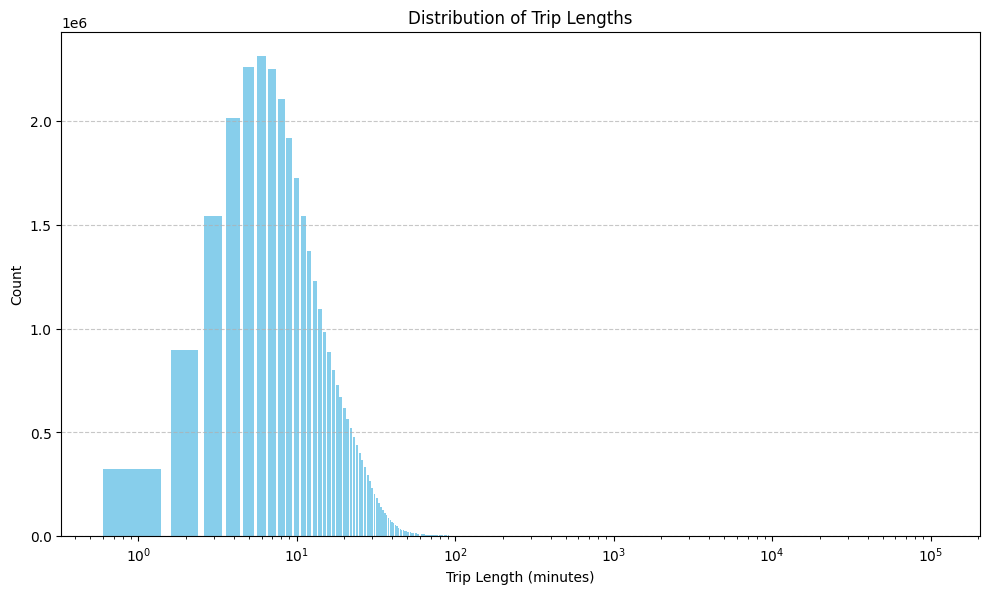

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(trip_length_results['triplength'], trip_length_results['count'], color='skyblue')
plt.xlabel('Trip Length (minutes)')
plt.ylabel('Count')
plt.title('Distribution of Trip Lengths')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xscale('log') #use a log scale on X axis
plt.show()

In [37]:
# And one other look lets see some percentiles
data = np.repeat(trip_length_results['triplength'], trip_length_results['count'])

# Calculate the percentiles
ps = [50, 75, 90, 99, 99.9]
trip_length_percentiles = np.percentile(data, ps)
print("50th percentile:", trip_length_percentiles[0])
print("75th percentile:", trip_length_percentiles[1])
print("90th percentile:", trip_length_percentiles[2])
print("99th percentile:", trip_length_percentiles[3])
print("99.9th percentile:", trip_length_percentiles[4])


50th percentile: 10.0
75th percentile: 17.0
90th percentile: 26.0
99th percentile: 64.0
99.9th percentile: 361.0


In [13]:
# Whether you chop off the top 1% or .1% you can see some of these bikes are out for WAY longer than the avg. 10m.
# now lets try something different.
# To find a missing bike we can look at the data in two ways
# 1) bikes with triptime in the ~99th+ percentile (DONE)
# 2) bikes that are in the ~90th+ percentile when normalizing for distance traveled
# Let's use start/stop lat/long to create a new distance column and get a miles/hour 
# It takes too long to compute distance for every bike, so we will limit our search to bikes in the 75th+ percentile

kmph_query = """

CREATE TEMP FUNCTION SAFE_ACOS(x FLOAT64) AS (
  IF(x >= -1 AND x <= 1, ACOS(x), NULL)
);

CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
  IFNULL(SAFE_ACOS(x), IF(x > 1, 0.0, ACOS(-1)) * x / 180)
);

WITH Trips AS (
  SELECT
    bikeid,
    start_station_id,
    end_station_id,
    start_station_latitude AS start_lat,
    start_station_longitude AS start_lon,
    end_station_latitude AS stop_lat,
    end_station_longitude AS stop_lon,
    starttime AS start_time,
    stoptime AS stop_time
  FROM
    `bigquery-public-data.new_york.citibike_trips`
  WHERE
    start_station_latitude IS NOT NULL
    AND start_station_longitude IS NOT NULL
    AND end_station_latitude IS NOT NULL
    AND end_station_longitude IS NOT NULL
    AND starttime IS NOT NULL
    AND stoptime IS NOT NULL
)

SELECT
  bikeid,
  start_station_id,
  end_station_id,
  start_time,
  stop_time,
  TIMESTAMP_DIFF(stop_time, start_time, SECOND) AS time_diff_seconds,
  (6371 * ACOS(COS(RADIANS(start_lat)) * COS(RADIANS(stop_lat)) * COS(RADIANS(start_lon) - RADIANS(stop_lon)) + SIN(RADIANS(start_lat)) * SIN(RADIANS(stop_lat)))) AS distance_km,
  (6371 * ACOS(COS(RADIANS(start_lat)) * COS(RADIANS(stop_lat)) * COS(RADIANS(start_lon) - RADIANS(stop_lon)) + SIN(RADIANS(start_lat)) * SIN(RADIANS(stop_lat)))) / TIMESTAMP_DIFF(stop_time, start_time, SECOND) * 3600 AS speed_kph
FROM
  Trips
"""
kmph_results = gpd.read_gbq(kmph_query, project_id=project_id).dropna()

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [19]:
kmph_results.head()

,bikeid,start_station_id,end_station_id,start_time,stop_time,time_diff_seconds,distance_km,speed_kph
0,21108,232,391,2015-07-09 12:26:24+00:00,2015-07-09 12:51:24+00:00,1500,0.366573,0.879775
1,16726,344,396,2015-06-30 09:02:00+00:00,2015-06-30 09:07:00+00:00,300,0.217931,2.615171
2,26101,344,3072,2016-08-31 17:18:56+00:00,2016-08-31 17:32:00+00:00,784,0.818757,3.759599
3,17994,490,482,2016-06-01 21:48:34+00:00,2016-06-01 21:59:14+00:00,640,0.598655,3.367432
4,16189,490,457,2013-07-16 08:09:29+00:00,2013-07-16 08:23:37+00:00,848,1.361100,5.778256


In [40]:
# Calculate the percentiles
# we go down not up since we're looking for slow riders while before we were looking for long trips.
kmph_results = kmph_results.loc[kmph_results['speed_kph'] > 0]
speed_ps = [50, 25, 10, 1, .1]
speed_percentiles = np.percentile(kmph_results['speed_kph'], speed_ps)
print("50th percentile:", speed_percentiles[0])
print("25th percentile:", speed_percentiles[1])
print("10th percentile:", speed_percentiles[2])
print("1st percentile:", speed_percentiles[3])
print("0.1th percentile:", speed_percentiles[4])


50th percentile: 6.039980359685741
25th percentile: 2.9028936881174374
10th percentile: 1.1185097665343484
1st percentile: 0.1026048545188629
0.1th percentile: 0.008802215560217663


In [32]:
# Let's see where these two datasets collide. Get all rows where time_diff_seconds > 64*60 (99th percentile trip length)
# where also mph is in the bottom 10th percentile
probably_missing = kmph_results.loc[(kmph_results['speed_kph'] < speed_percentiles[2]) & (kmph_results['time_diff_seconds'] > trip_length_percentiles[3])]
print(len(probably_missing))

3255515


In [33]:
# This number is ~10% of our total trips, which means practically 100% of the rows with speed_kph in the bottom 10 percentile
# also were in the 99th percentile for trip length. What about the 90th percentile?
probably_missing = kmph_results.loc[(kmph_results['speed_kph'] < speed_percentiles[2]) & (kmph_results['time_diff_seconds'] > trip_length_percentiles[2])]
print(len(probably_missing))

3255734


In [41]:
# Once again we see ~10%. That means so far speed and triplength are very correlated.
# Let's put this to the test and graph each intersection . . . [50%speed,50%triplength] . . . [.1%speed, 99.9th triplength]
# Our hypothesis is if they're equally as effective, then we should see floor(speed,triplength) distribution at each step
for i in range(0,len(ps)):
    percentile_results = kmph_results.loc[(kmph_results['speed_kph'] < speed_percentiles[i]) & (kmph_results['time_diff_seconds'] > trip_length_percentiles[i])]
    print("percentile is {} len(results) / num_trips is is {}".format(speed_ps[i], len(percentile_results)/num_trips))

percentile is 50 len(results) / num_trips is is 0    0.48857
Name: num_trips, dtype: Float64
percentile is 25 len(results) / num_trips is is 0    0.244285
Name: num_trips, dtype: Float64
percentile is 10 len(results) / num_trips is is 0    0.097714
Name: num_trips, dtype: Float64
percentile is 1 len(results) / num_trips is is 0    0.009771
Name: num_trips, dtype: Float64
percentile is 0.1 len(results) / num_trips is is 0    0.000795
Name: num_trips, dtype: Float64


In [ ]:
# It worked! We see 48vs50, 24.4vs25, 9.7vs10,.97vs1, and .08vs.1
# This confirms that these two metrics are very highly corelated.